In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

Building Data Loading Functions:

In [5]:
import gdown

In [6]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=4428fb68-a31a-473a-87e4-033e55a56b64
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 107MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [7]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [10]:
char_to_num.get_vocabulary()

['',
 np.str_('a'),
 np.str_('b'),
 np.str_('c'),
 np.str_('d'),
 np.str_('e'),
 np.str_('f'),
 np.str_('g'),
 np.str_('h'),
 np.str_('i'),
 np.str_('j'),
 np.str_('k'),
 np.str_('l'),
 np.str_('m'),
 np.str_('n'),
 np.str_('o'),
 np.str_('p'),
 np.str_('q'),
 np.str_('r'),
 np.str_('s'),
 np.str_('t'),
 np.str_('u'),
 np.str_('v'),
 np.str_('w'),
 np.str_('x'),
 np.str_('y'),
 np.str_('z'),
 np.str_("'"),
 np.str_('?'),
 np.str_('!'),
 np.str_('1'),
 np.str_('2'),
 np.str_('3'),
 np.str_('4'),
 np.str_('5'),
 np.str_('6'),
 np.str_('7'),
 np.str_('8'),
 np.str_('9'),
 np.str_(' ')]

In [11]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [12]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [13]:


def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]



In [14]:
def load_data(path: tf.Tensor):
    # Decode TensorFlow tensor to string
    path = path.numpy().decode("utf-8")

    # Normalize path to avoid issues
    path = os.path.normpath(path)

    # Extract filename without extension
    file_name = os.path.splitext(os.path.basename(path))[0]

    # Construct file paths
    video_path = os.path.join("data", "s1", f"{file_name}.mpg")
    alignment_path = os.path.join("data", "alignments", "s1", f"{file_name}.align")

    # Debugging: Print extracted values
    print("Decoded Path:", path)
    print("Extracted file_name:", file_name)
    print("Video Path:", video_path)
    print("Alignment Path:", alignment_path)

    # Check if files exist
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")
    if not os.path.exists(alignment_path):
        raise FileNotFoundError(f"Alignment file not found: {alignment_path}")

    # Load video frames and alignments
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [15]:
test_path = "./data/s1/bbal6n.mpg"

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]


'bbal6n'

In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

Decoded Path: data/s1/bbal6n.mpg
Extracted file_name: bbal6n
Video Path: data/s1/bbal6n.mpg
Alignment Path: data/alignments/s1/bbal6n.align


In [18]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.4603736 ],
         [ 1.4603736 ],
         [ 1.4209042 ],
         ...,
         [ 0.15787823],
         [ 0.19734779],
         [ 0.07893912]],

        [[ 1.4603736 ],
         [ 1.4603736 ],
         [ 1.4209042 ],
         ...,
         [ 0.15787823],
         [ 0.07893912],
         [ 0.03946956]],

        [[ 1.4209042 ],
         [ 1.4209042 ],
         [ 1.3814346 ],
         ...,
         [ 0.07893912],
         [ 0.07893912],
         [ 0.07893912]],

        ...,

        [[ 0.9472694 ],
         [ 0.9472694 ],
         [ 0.9472694 ],
         ...,
         [ 9.946329  ],
         [ 9.86739   ],
         [ 9.86739   ]],

        [[ 0.9472694 ],
         [ 0.9472694 ],
         [ 0.9472694 ],
         ...,
         [ 9.906859  ],
         [ 9.86739   ],
         [ 9.86739   ]],

        [[ 0.9472694 ],
         [ 0.9472694 ],
         [ 0.9472694 ],
         ...,
         [ 9.906859  ],
         [ 9.86739

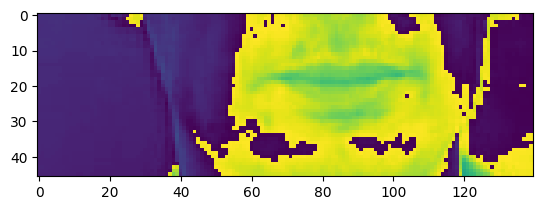

In [19]:
plt.imshow(frames[4])

In [20]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [21]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [22]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [23]:
def mappable_function(path:tf.Tensor) ->List[tf.Tensor]:
    result = tf.py_function(load_data, inp=[path], Tout=(tf.float32, tf.int64))
    return result

Create Data Pipelines:

In [24]:
from matplotlib import pyplot as plt

In [25]:
data = tf.data.Dataset.list_files("./data/s1/*.mpg")
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [26]:
frames, alignments = data.as_numpy_iterator().next()

Decoded Path: data/s1/sban2n.mpg
Extracted file_name: sban2n
Video Path: data/s1/sban2n.mpg
Alignment Path: data/alignments/s1/sban2n.align
Decoded Path: data/s1/prbx2n.mpg
Extracted file_name: prbx2n
Video Path: data/s1/prbx2n.mpg
Alignment Path: data/alignments/s1/prbx2n.align


In [27]:
frames

array([[[[[ 1.5018662 ],
          [ 1.5018662 ],
          [ 1.1856838 ],
          ...,
          [ 0.31618235],
          [ 0.27665955],
          [ 0.27665955]],

         [[ 1.6994802 ],
          [ 1.541389  ],
          [ 1.1856838 ],
          ...,
          [ 0.31618235],
          [ 0.27665955],
          [ 0.27665955]],

         [[ 1.541389  ],
          [ 1.541389  ],
          [ 1.4623433 ],
          ...,
          [ 0.27665955],
          [ 0.27665955],
          [ 0.27665955]],

         ...,

         [[ 1.0671154 ],
          [ 1.0671154 ],
          [ 1.0671154 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.0275927 ],
          [ 1.0275927 ],
          [ 1.0275927 ],
          ...,
          [10.078313  ],
          [10.078313  ],
          [10.078313  ]],

         [[ 1.0275927 ],
          [ 1.0275927 ],
          [ 1.0275927 ],
          ...,
          [10.078313  ],
          [10.078313  ],
          

In [28]:
alignments

array([[19,  5, 20, 39,  2, 12, 21,  5, 39,  1, 20, 39, 14, 39, 20, 23,
        15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [16, 12,  1,  3,  5, 39, 18,  5,  4, 39,  2, 25, 39, 24, 39, 20,
        23, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [29]:
len(frames)

2

In [30]:
len(alignments)

2

In [31]:
test = data.as_numpy_iterator()

In [32]:
val = test.next()

Decoded Path: data/s1/swbo8n.mpg
Extracted file_name: swbo8n
Video Path: data/s1/swbo8n.mpg
Alignment Path: data/alignments/s1/swbo8n.align
Decoded Path: data/s1/lrbr6p.mpg
Extracted file_name: lrbr6p
Video Path: data/s1/lrbr6p.mpg
Alignment Path: data/alignments/s1/lrbr6p.align
Decoded Path: data/s1/sria6n.mpg
Extracted file_name: sria6n
Video Path: data/s1/sria6n.mpg
Alignment Path: data/alignments/s1/sria6n.align


In [33]:
val[0]

array([[[[[1.4514568 ],
          [1.4514568 ],
          [1.4132606 ],
          ...,
          [0.15278493],
          [0.15278493],
          [0.15278493]],

         [[1.4514568 ],
          [1.4514568 ],
          [1.4132606 ],
          ...,
          [0.15278493],
          [0.15278493],
          [0.15278493]],

         [[1.2986718 ],
          [1.2986718 ],
          [1.2986718 ],
          ...,
          [0.11458869],
          [0.11458869],
          [0.11458869]],

         ...,

         [[0.87851334],
          [0.87851334],
          [0.87851334],
          ...,
          [9.472666  ],
          [9.62545   ],
          [9.62545   ]],

         [[0.87851334],
          [0.87851334],
          [0.87851334],
          ...,
          [9.472666  ],
          [9.549058  ],
          [9.472666  ]],

         [[0.87851334],
          [0.87851334],
          [0.87851334],
          ...,
          [9.510861  ],
          [9.549058  ],
          [9.472666  ]]],


        [[[1.3368

In [34]:
import imageio

frames = val[0][0]  # Shape (75, 46, 140, 1)

# Convert float32 (0-1) to uint8 (0-255)
frames = (frames * 255).astype(np.uint8)

# Remove the last dimension (1-channel) and expand to 3 channels (RGB)
frames = np.repeat(frames, 3, axis=-1)  # Shape now (75, 46, 140, 3)

# Save as GIF
imageio.mimsave('./animation.gif', frames, fps=10)


In [35]:
print(val[0][0].shape)

(75, 46, 140, 1)


Decoded Path: data/s1/pwad2n.mpg
Extracted file_name: pwad2n
Video Path: data/s1/pwad2n.mpg
Alignment Path: data/alignments/s1/pwad2n.align


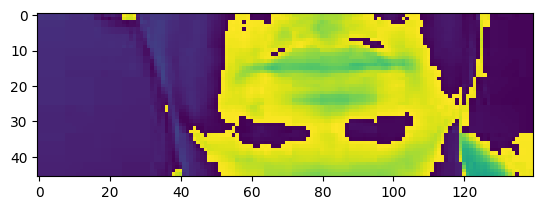

In [36]:
plt.imshow(val[0][0][0])

In [37]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white by o eight now'>

Designing a Deep Neural Network:

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import MaxPool3D, Activation, Reshape, SpatialDropout3D
from tensorflow.keras.layers import BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# ✅ Load & Preprocess Dataset
def load_data():
    """Simulate dataset loading. Replace with actual dataset fetching logic."""
    num_samples = 1000  # Example dataset size
    frames, height, width, channels = 75, 46, 140, 1  # Video frame dimensions
    num_classes = 30  # Example vocabulary size

    # Generate random video data and labels
    x_data = tf.random.normal((num_samples, frames, height, width, channels))
    y_data = tf.random.uniform((num_samples,), minval=0, maxval=num_classes, dtype=tf.int32)

    # Convert labels to sparse categorical format for CTC loss
    y_data = tf.one_hot(y_data, depth=num_classes)

    return x_data, y_data

# ✅ Convert Data to TensorFlow Dataset
def convert_to_dataset(x_data, y_data, batch_size):
    """Converts NumPy arrays to a TensorFlow dataset with batching."""
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    return dataset.batch(batch_size)

# Load data
batch_size = 16
x_train, y_train = load_data()
x_test, y_test = load_data()

# Convert to dataset
train = convert_to_dataset(x_train, y_train, batch_size)
test = convert_to_dataset(x_test, y_test, batch_size)

# ✅ Define Model
model = Sequential([
    Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same', activation='relu'),
    MaxPool3D((1, 2, 2)),

    Conv3D(256, 3, padding='same', activation='relu'),
    MaxPool3D((1, 2, 2)),

    Conv3D(75, 3, padding='same', activation='relu'),
    MaxPool3D((1, 2, 2)),

    TimeDistributed(Flatten()),

    Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
    Dropout(0.5),

    Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)),
    Dropout(0.5),

    Dense(31, kernel_initializer='he_normal', activation='softmax')  # 30 classes + 1 blank for CTC
])

# ✅ Checkpoint Callback
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('models', 'checkpoint.weights.h5'),
    monitor='loss',
    save_weights_only=True
)

# ✅ Learning Rate Scheduler
def scheduler(epoch, lr):
    return lr if epoch < 30 else lr * tf.math.exp(-0.1)

schedule_callback = LearningRateScheduler(scheduler)

# ✅ Custom Callback for Predictions
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        self.dataset = iter(dataset)  # Convert to an iterator

    def on_epoch_end(self, epoch, logs=None):
        try:
            data = next(self.dataset)  # Get next batch
            yhat = self.model.predict(data[0])

            # Decode predictions
            decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75] * batch_size, greedy=False)[0][0].numpy()

            for x in range(len(yhat)):
                print('Original:', tf.strings.reduce_join(tf.strings.as_string(data[1][x])).numpy().decode('utf-8'))
                print('Prediction:', tf.strings.reduce_join(tf.strings.as_string(decoded[x])).numpy().decode('utf-8'))
                print('~' * 100)
        except StopIteration:
            print("End of dataset reached.")

example_callback = ProduceExample(test)

# ✅ Define CTC Loss Function
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

# ✅ Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

# ✅ Train Model
model.fit(
    train,
    validation_data=test,
    epochs=100,
    callbacks=[checkpoint_callback, schedule_callback, example_callback]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


In [ ]:
 url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

sample = test_data.next()

yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]